# Predicting Road Accident Risk: A LightGBM Approach

## 1. Introduction & Goal

This notebook focuses on building a predictive model for the "Predicting Road Accident Risk" competition. It serves as the second part of my analysis, building directly upon the insights gained from my comprehensive **[Exploratory Data Analysis (EDA) Notebook](https://www.kaggle.com/code/anwarabualhussien/full-eda-understanding-the-data)**, which was awarded a bronze medal.

**Our key takeaways from the EDA were:**
*   The target variable `accident_risk` is slightly right-skewed but well-behaved.
*   `curvature` and `speed_limit` have the strongest positive linear correlation with risk.


The goal of this notebook is to implement a robust modeling pipeline, train a powerful LightGBM model, and generate a submission file.

## 2. Notebook Workflow
1.  **Setup & Imports:** Load necessary libraries.
2.  **Data Preparation:** Load data and apply the crucial preprocessing steps identified in the EDA.
3.  **Preprocessing Pipeline:** Systematically handle categorical and numerical features.
4.  **Model Training:** Train a LightGBM Regressor using a 5-Fold Cross-Validation strategy for robust evaluation.
5.  **Feature Importance:** Visualize which features the model found most important.
6.  **Submission:** Generate the `submission.csv` file.

In [1]:
# =============================================================================
# 1. SETUP AND IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# For reproducibility of results
SEED = 42

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:


# 2. DATA PREPARATION

# Load the datasets
train_df  = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test_df= pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")


print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)



Train data shape: (517754, 14)
Test data shape: (172585, 13)


In [3]:
 train_df.head()


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [4]:
 test_df.head()


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [5]:
# Store test IDs for final submission file
test_ids = test_df['id']

In [6]:
# This is safer and can be run multiple times
train_df = train_df.drop("id", axis=1, errors='ignore')
test_df = test_df.drop("id", axis=1, errors='ignore')

In [7]:
# Separate features (X) and target (y)
X = train_df.drop('accident_risk', axis=1)
y = train_df['accident_risk']
X_test = test_df

## 3. Preprocessing Pipeline

To prepare the data for our LightGBM model, we need to perform two key steps:
1.  **One-Hot Encode Categorical Features:** Convert object columns into a numerical format.
2.  **Scale Numerical Features:** Standardize features like `curvature` and `speed_limit` so they have a mean of 0 and a standard deviation of 1. While LightGBM doesn't strictly require this, it can sometimes help.

In [8]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(include=np.number).columns

print(f"Categorical Features: {list(categorical_features)}")
print(f"Numerical Features: {list(numerical_features)}")

# Apply One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Align columns - crucial for when test set might miss a category
train_cols = X.columns
test_cols = X_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X[c] = 0

X_test = X_test[train_cols] # Ensure order is the same

# Apply Scaling
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nData preprocessed successfully.")
print("Shape of X_train after preprocessing:", X.shape)
print("Shape of X_test after preprocessing:", X_test.shape)

Categorical Features: ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']
Numerical Features: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

Data preprocessed successfully.
Shape of X_train after preprocessing: (517754, 16)
Shape of X_test after preprocessing: (172585, 16)


## 4. Model Training with 5-Fold Cross-Validation

We will use LightGBM, a powerful and efficient gradient boosting framework. To ensure our model's performance is robust and not due to a lucky data split, we will train it using a 5-Fold Cross-Validation strategy. We will train 5 separate models, and our final submission will be an average of their predictions.

In [9]:
# =============================================================================
# 4. MODEL TRAINING (LIGHTGBM WITH 5-FOLD CV AND GPU)
# =============================================================================
print("\nStarting model training with 5-Fold Cross-Validation...")

NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(X_test.shape[0])
feature_importances = pd.DataFrame(index=X.columns)

# LightGBM parameters - configured for GPU
lgb_params = {
    'objective': 'regression_l1', # MAE is often more robust to outliers
    'metric': 'rmse',
    'n_estimators': 10000,        # High number, will be stopped by early stopping
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 64,
    'verbose': -1,
    'n_jobs': -1,
    'seed': SEED,
    'boosting_type': 'gbdt',
    'device': 'gpu'               # <-- KEY PARAMETER FOR GPU USAGE
}

for n_fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

    model = lgb.LGBMRegressor(**lgb_params)
    
    model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(200, verbose=False)])

    # Store predictions
    oof_preds[valid_idx] = model.predict(X_valid)
    sub_preds += model.predict(X_test) / NFOLDS
    
    # Store feature importances
    feature_importances[f'fold_{n_fold+1}'] = model.feature_importances_
    
    fold_rmse = np.sqrt(mean_squared_error(y_valid, oof_preds[valid_idx]))
    print(f"Fold {n_fold+1} RMSE: {fold_rmse}")

# Calculate overall Out-of-Fold RMSE
overall_rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"\nOverall Out-of-Fold CV RMSE: {overall_rmse}")








Starting model training with 5-Fold Cross-Validation...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1 RMSE: 0.05645961075334417
Fold 2 RMSE: 0.05627496783859791
Fold 3 RMSE: 0.056315726420136276
Fold 4 RMSE: 0.056151331157999154
Fold 5 RMSE: 0.05613628728536719

Overall Out-of-Fold CV RMSE: 0.05626770935010672



Visualizing feature importances...


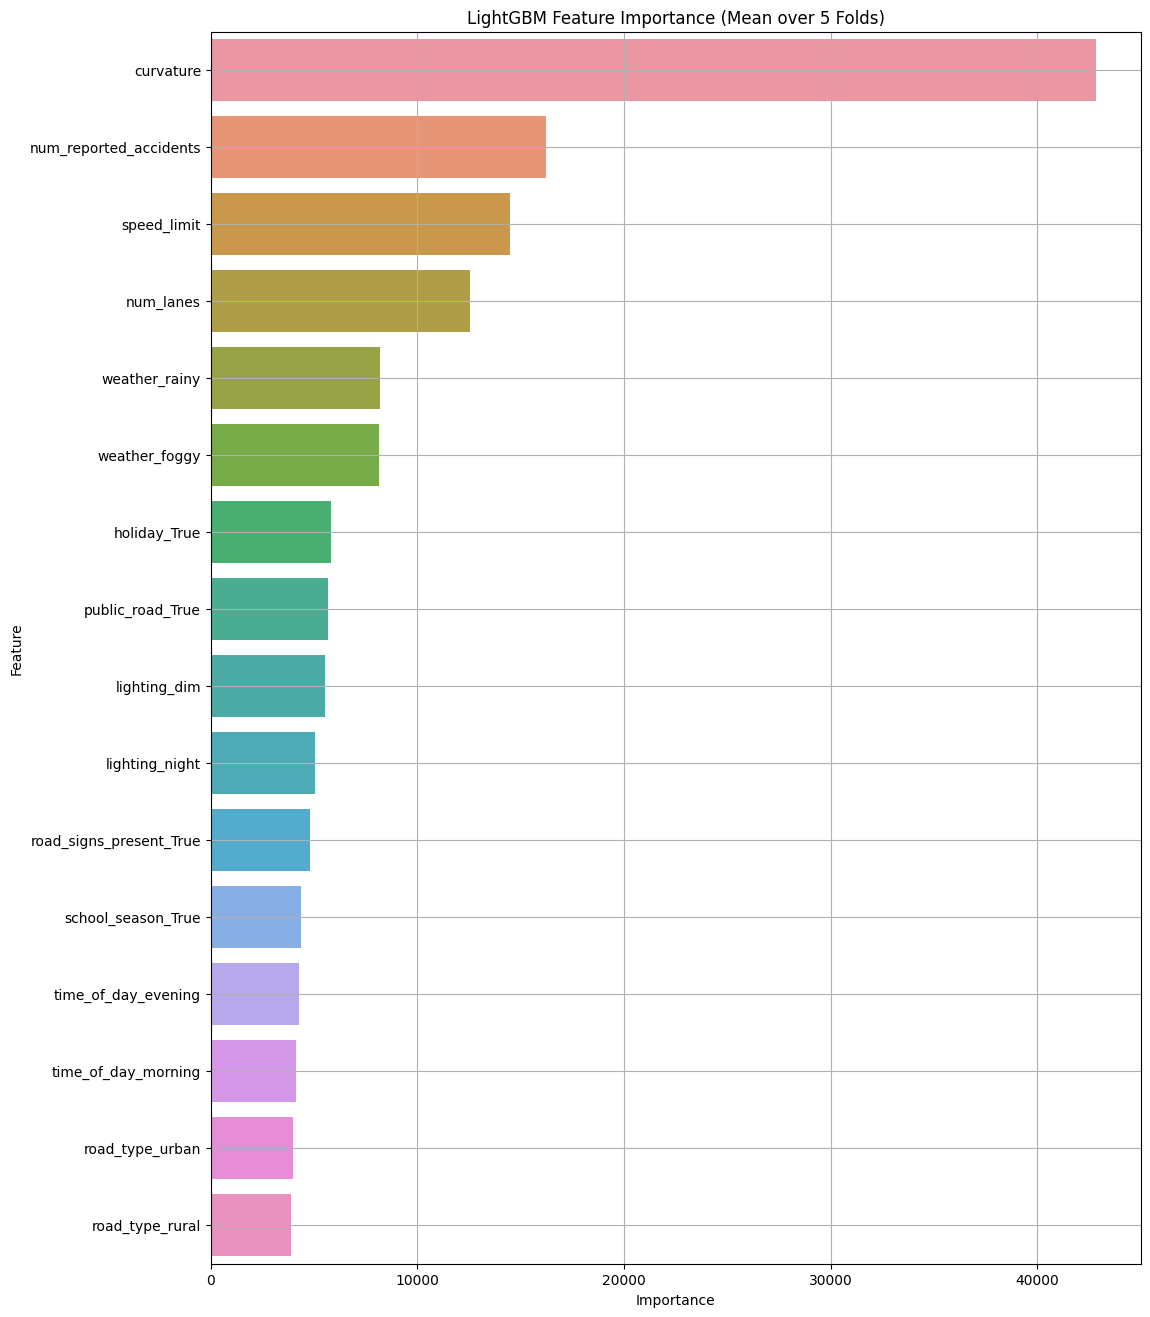

In [10]:
# =============================================================================
# 5. FEATURE IMPORTANCE VISUALIZATION
# =============================================================================
print("\nVisualizing feature importances...")

# Calculate mean importance across all folds
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(12, 16))
sns.barplot(x='mean', y=feature_importances.index, data=feature_importances)
plt.title('LightGBM Feature Importance (Mean over 5 Folds)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

In [11]:
# =============================================================================
# 6. GENERATE SUBMISSION FILE
# =============================================================================
print("\nGenerating submission file...")

submission_df = pd.DataFrame({'id': test_ids, 'accident_risk': sub_preds})
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print("Top 5 rows of the submission file:")
print(submission_df.head())


Generating submission file...

Submission file 'submission.csv' created successfully!
Top 5 rows of the submission file:
       id  accident_risk
0  517754       0.291109
1  517755       0.127382
2  517756       0.186421
3  517757       0.323132
4  517758       0.402633
